In [ ]:
import os
from pathlib import Path

root = Path(r"E:\Masters Thesis\source data\image data\THINGS")
images_dir = root / "images_THINGS" / "object_images"

## CONCEPTS, n=1854

In [ ]:
import os

base_dir = r"E:\Masters Thesis\source data\image data\THINGS\images_THINGS\object_images"

# List directories in that folder, = concepts
concepts = [
    name for name in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, name))
]

directory appetizer features 29 images
directory baby features 35 images
directory bee features 27 images
directory blind features 26 images
directory doorknocker features 28 images
directory gurney features 26 images
directory iguana features 26 images
directory owl features 27 images
directory parrot features 28 images
directory police_car features 30 images
directory puffin features 33 images
directory record_player features 28 images
directory sea_urchin features 27 images
directory wine features 26 images


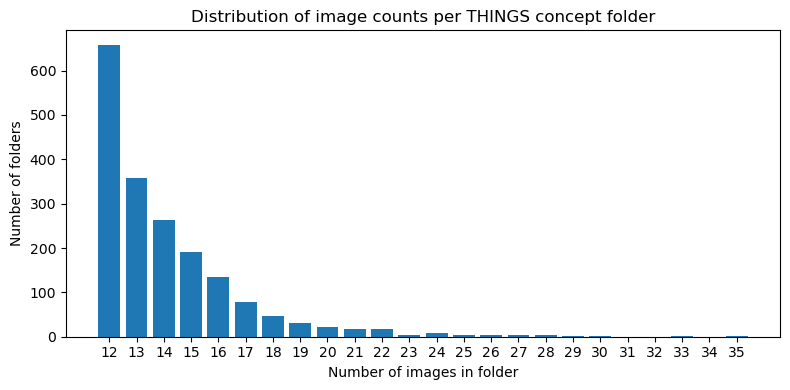

In [20]:
import os
from pathlib import Path
import matplotlib.pyplot as plt

base_dir = Path(r"E:\Masters Thesis\source data\image data\THINGS\images_THINGS\object_images")

image_exts = {".jpg"}

# 1. Count images per folder
folder_counts = []

for sub in base_dir.iterdir():
    if not sub.is_dir():
        continue
    n_imgs = sum(
        1
        for f in sub.iterdir()
        if f.is_file() and f.suffix.lower() in image_exts
    )
    if n_imgs > 25:
        print(f"directory {sub.name} features {n_imgs} images")
    folder_counts.append(n_imgs)

# 2. Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(
    folder_counts,
    bins=range(min(folder_counts), max(folder_counts) + 2),  # one bin per integer count
    align="left",
    rwidth=0.8,
)
plt.xlabel("Number of images in folder")
plt.ylabel("Number of folders")
plt.title("Distribution of image counts per THINGS concept folder")
plt.xticks(range(min(folder_counts), max(folder_counts) + 1))
plt.tight_layout()
plt.show()


## Categories, n=27

### Handling Missing Categories in `concepts-metadata_things.tsv`

The file `concepts-metadata_things.tsv` has **one row per concept** (1,854 total) and several *category-related* columns:

- `Bottom-up Category (Human Raters)`
- `Top-down Category (WordNet)`
- `Top-down Category (manual selection)`
- `All Bottom-up Categories`

! Some entries are `NaN` in one or more of these columns.

---

#### 1. What each category column means

**1. `Bottom-up Category (Human Raters)`**

- A **single, cleaned category label chosen by humans**
- Derived from crowd workers:
  - Free category naming → cleaning / merging synonyms → second round where workers vote for the best label.
- `NaN` here usually means: workers **did not converge** on a clear high-level category that fits the “core 27” categories.

---

**2. `Top-down Category (WordNet)`**

- A **taxonomy-based category** derived from **WordNet**.
- For each concept’s synset (e.g. `acorn.n.01`), the authors:
  - Traverse its hypernym (is-a) paths in WordNet.
  - Check if the path passes through one of the predefined category synsets (e.g. `animal.n.01`, `fruit.n.01`, `musical_instrument.n.01`, …).
- `NaN` here means: the concept’s synset did **not** clearly fall under one of those selected category synsets.

---

**3. `Top-down Category (manual selection | PREFERED)`**

- A **curated / cleaned version** of the top-down category.
- The authors manually adjust or choose a more useful label when:
  - WordNet gives something too specific or weird,
  - or when multiple WordNet categories could apply.
- This is often the **most polished single category label** to use.
- `NaN` here means: they chose **not** to assign a manual top-down label (concept is ambiguous or doesn’t fit neatly).

---

**4. `All Bottom-up Categories`**

- A **list of all raw category labels** that human raters produced for that concept before collapsing to a single best label.
- Often looks like a semicolon-separated list, e.g. `"home decor; furniture; decoration"`.
- Even when `Bottom-up Category (Human Raters)` is `NaN`, this field can still contain **useful raw labels** (i.e. what people wrote, even if they didn’t agree on one).


In [29]:
import pandas as pd
from pathlib import Path

concepts_path = Path(r"E:\Masters Thesis\source data\image data\THINGS\concepts-metadata_things.tsv")

concepts = pd.read_csv(concepts_path, sep="\t")
print(concepts.shape)
print(concepts.columns)
#concepts.head()


(1854, 25)
Index(['Word', 'uniqueID', 'WordNet ID', 'Wordnet ID2', 'Wordnet ID3',
       'Wordnet ID4', 'WordNet Synonyms',
       'Definition (from WordNet, Google, or Wikipedia)', 'Bigram',
       'Percent_known', 'Rank (combining COCA/concreteness)',
       'Concreteness (M)', 'COCA word freq (online)', 'COCA word freq',
       'COCA (dispersion)', 'COCA (rank)', 'BNC freq', 'SUBTLEX freq',
       'Dominant Part of Speech', 'Bottom-up Category (Human Raters)',
       'Top-down Category (WordNet)', 'Top-down Category (manual selection)',
       'All Bottom-up Categories', 'Number of word meanings in list',
       'Example image'],
      dtype='object')


In [54]:
# Check for NAs
cols = [
    "Bottom-up Category (Human Raters)",
    "Top-down Category (WordNet)",
    "Top-down Category (manual selection)",
    "All Bottom-up Categories",
]

concepts[cols].isna().sum()


Bottom-up Category (Human Raters)       928
Top-down Category (WordNet)             894
Top-down Category (manual selection)    559
All Bottom-up Categories                  0
dtype: int64

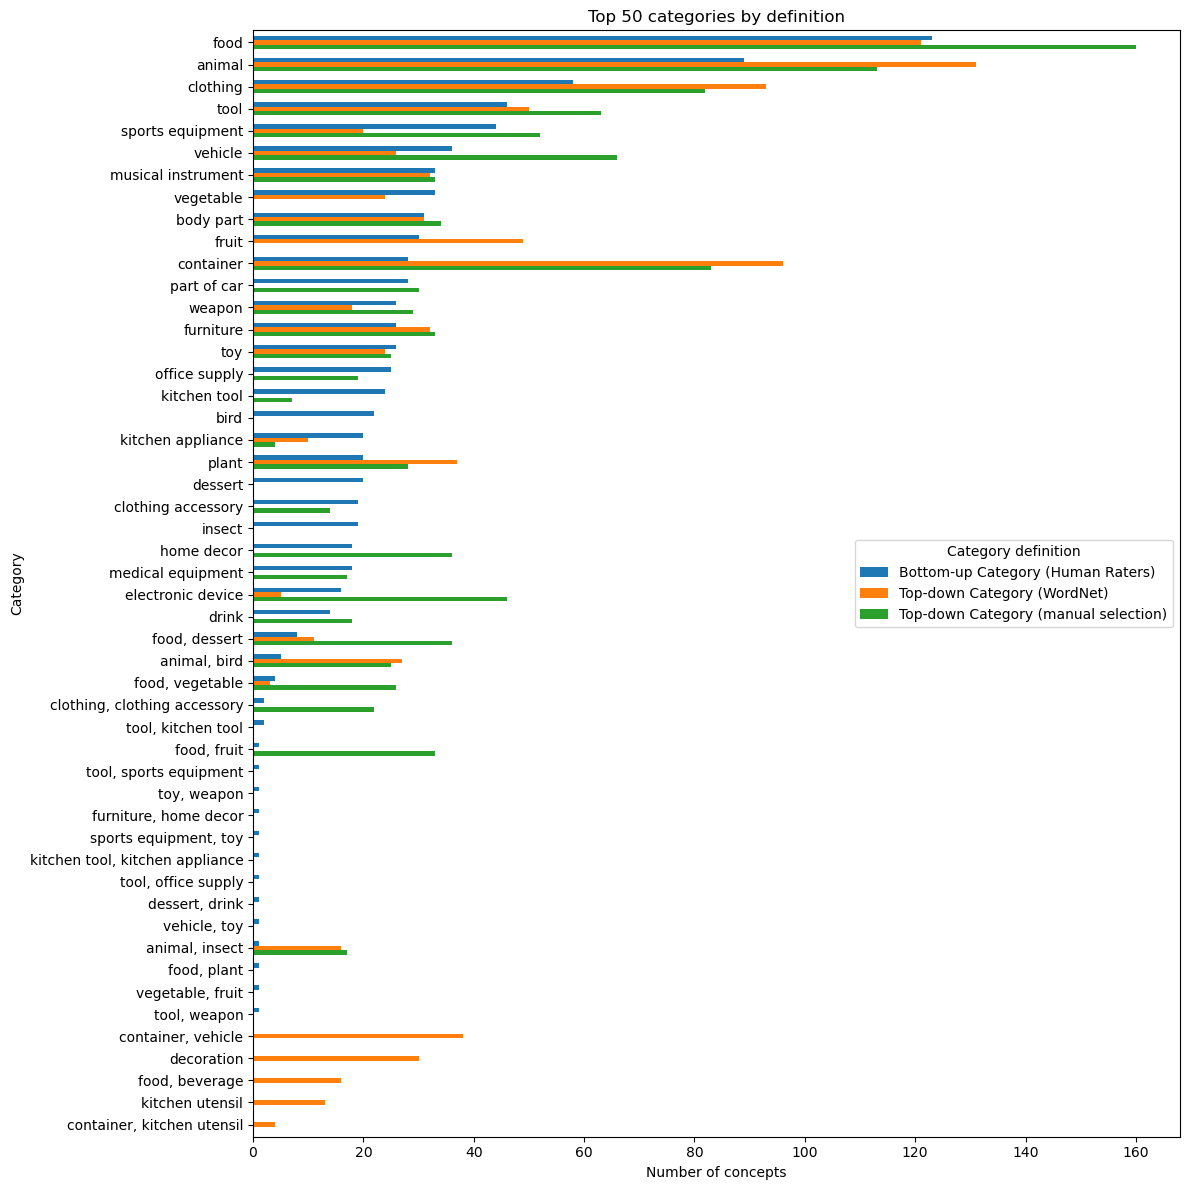

In [91]:
import matplotlib.pyplot as plt
import pandas as pd

# category columns you want to compare
cat_cols = [
    "Bottom-up Category (Human Raters)",
    "Top-down Category (WordNet)",
    "Top-down Category (manual selection)",
]

# 1. value_counts for each definition
count_dict = {}
for col in cat_cols:
    vc = concepts[col].value_counts()
    count_dict[col] = vc

# 2. combine into one DataFrame (index = category string)
counts_df = pd.concat(count_dict, axis=1).fillna(0).astype(int)
# columns look like:
#   "Bottom-up Category (Human Raters)", "Top-down Category (WordNet)", ...

# 3. choose top-k categories based on bottom-up definition
k = 50
base_col = "Bottom-up Category (Human Raters)"
topk_index = counts_df.sort_values(by=base_col, ascending=False).head(k).index

subset = counts_df.loc[topk_index]

# 4. plot grouped barh (each column = one "category definition")
plt.figure(figsize=(12, 12))
subset.plot(kind="barh", ax=plt.gca(), width = 0.6)
plt.gca().invert_yaxis()
plt.xlabel("Number of concepts")
plt.ylabel("Category")
plt.title(f"Top {k} categories by definition")
plt.legend(title="Category definition", loc= 'center right')
plt.tight_layout()
plt.show()


In [ ]:
# Check which concepts have no category

In [ ]:
cols = [
    "Bottom-up Category (Human Raters)",
    "Top-down Category (WordNet)",
    "Top-down Category (manual selection)",
]

# mask: True where *all* three category fields are NaN
no_cat_mask = concepts[cols].isna().all(axis=1)

# subset of concepts with no valid category assigned
no_cat_concepts = concepts[no_cat_mask]

print("Number of concepts with NO valid category ~ 25.6%, absolute:", no_cat_concepts.shape[0])

# inspect a few
no_cat_concepts[["Word"] + cols].head(5)


Number of concepts with NO valid category ~ 25.6%, absolute: 475


,Word,Bottom-up Category (Human Raters),Top-down Category (WordNet),Top-down Category (manual selection)
16,altar,NaN,NaN,NaN
17,aluminum foil,NaN,NaN,NaN
18,amber,NaN,NaN,NaN
21,anchor,NaN,NaN,NaN
27,antenna,NaN,NaN,NaN
35,arch,NaN,NaN,NaN
44,awning,NaN,NaN,NaN
46,baby,NaN,NaN,NaN
47,backdrop,NaN,NaN,NaN
48,backgammon,NaN,NaN,NaN


## Load Alexnet

In [40]:
# If you don't have torch/torchvision yet, uncomment the next line:
# !pip install torch torchvision --quiet

import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os


In [41]:
# Pick device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Try new weights API first, fall back to older one
try:
    from torchvision.models import AlexNet_Weights
    weights = AlexNet_Weights.DEFAULT
    alexnet = models.alexnet(weights=weights).to(device)
    imagenet_labels = weights.meta["categories"]
except Exception:
    alexnet = models.alexnet(pretrained=True).to(device)
    # If this errors because labels are missing, see below for manual labels
    import json, urllib.request
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    imagenet_labels = urllib.request.urlopen(url).read().decode("utf-8").splitlines()

alexnet.eval()
print("AlexNet loaded.")


Using device: cpu


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Radovan/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:24<00:00, 10.2MB/s] 


AlexNet loaded.


In [42]:
# Standard ImageNet preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225],   # ImageNet std
    ),
])


def classify_with_alexnet(img_path, topk=5, show_image=True):
    """
    Load an image from disk, run AlexNet, and print top-k predictions.
    """
    assert os.path.exists(img_path), f"File not found: {img_path}"

    # Load and preprocess
    img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0).to(device)  # add batch dim

    # Forward pass
    with torch.no_grad():
        logits = alexnet(input_batch)
        probs = torch.softmax(logits, dim=1)[0]

    # Get top-k indices
    top_probs, top_idxs = probs.topk(topk)
    top_probs = top_probs.cpu().numpy()
    top_idxs = top_idxs.cpu().numpy()

    # Print predictions
    print(f"\nPredictions for: {img_path}")
    for p, idx in zip(top_probs, top_idxs):
        label = imagenet_labels[idx] if imagenet_labels is not None else str(idx)
        print(f"  {p*100:5.2f}%  –  {idx}: {label}")

    # Show image
    if show_image:
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(img_path))
        plt.show()



Predictions for: E:\Masters Thesis\source data\image data\THINGS\images_THINGS\object_images\abacus\abacus_03s.jpg
  95.46%  –  398: abacus
   1.18%  –  772: safety pin
   0.69%  –  692: packet
   0.34%  –  584: hair slide
   0.33%  –  709: pencil box


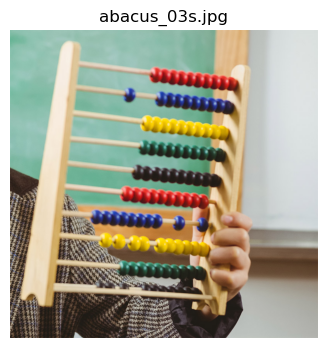

In [ ]:
# Single image
img_path = r"E:\Masters Thesis\source data\image data\THINGS\images_THINGS\object_images\abacus\abacus_03s.jpg"
classify_with_alexnet(img_path, topk=5)



Predictions for: E:\Masters Thesis\source data\image data\THINGS\images_THINGS\object_images\aquarium\aquarium_01b.jpg
  33.98%  –  664: monitor
  20.71%  –  782: screen
  11.27%  –  548: entertainment center
  10.82%  –  527: desktop computer
   7.86%  –  851: television


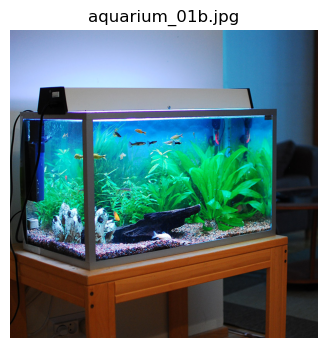


Predictions for: E:\Masters Thesis\source data\image data\THINGS\images_THINGS\object_images\aquarium\aquarium_02s.jpg
  32.63%  –  183: Kerry blue terrier
   7.36%  –  199: Scotch terrier
   3.25%  –  265: toy poodle
   3.12%  –  233: Bouvier des Flandres
   2.82%  –  406: altar


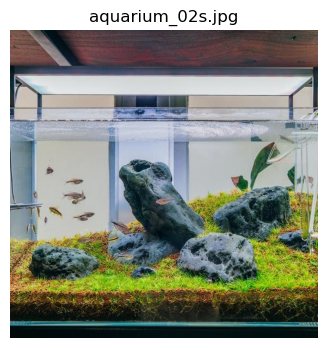

In [ ]:
# whole folder

def classify_some_in_folder(folder, n=12):
    folder = Path(folder)
    imgs = [p for p in folder.iterdir() if p.suffix.lower() in {".jpg"}]
    for p in imgs[:n]:
        classify_with_alexnet(str(p), topk=5)

# Example:
dict_path = r"E:\Masters Thesis\source data\image data\THINGS\images_THINGS\object_images\aquarium"
classify_some_in_folder(dict_path, n=2)
